# 1. Import Libraries

In [117]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder , StandardScaler , LabelEncoder
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor , RandomForestClassifier
from sklearn.metrics import mean_absolute_error , accuracy_score , mean_squared_error, r2_score , mean_squared_error as root_mean_squared_error

# 2. Load Data

In [118]:
df = pd.read_csv('insurance_dirty2.csv')
print(f"Initial shape: {df.shape}")
df.head()

Initial shape: (1275, 7)


,age,sex,bmi,children,smoker,region,charges
0,18.0,male,33.770,1.0,no,southeast,1725.55230
1,28.0,male,33.000,3.0,no,southeast,4449.46200
2,33.0,male,22.705,0.0,no,northwest,21984.47061
3,32.0,male,28.880,0.0,no,northwest,3866.85520
4,31.0,female,30.115,0.0,no,southeast,3756.62160


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1275 non-null   float64
 1   sex       1274 non-null   object 
 2   bmi       1273 non-null   float64
 3   children  1274 non-null   float64
 4   smoker    1274 non-null   object 
 5   region    1273 non-null   object 
 6   charges   1275 non-null   float64
dtypes: float64(4), object(3)
memory usage: 69.9+ KB


# 3. Check Missing Values

In [120]:
print("\n" + "="*50)
print("Missing values per column:")
print(df.isnull().sum())
print("\nMissing values percentage:")
print((df.isnull().sum() / len(df) * 100).round(2))


Missing values per column:
age         0
sex         1
bmi         2
children    1
smoker      1
region      2
charges     0
dtype: int64

Missing values percentage:
age         0.00
sex         0.08
bmi         0.16
children    0.08
smoker      0.08
region      0.16
charges     0.00
dtype: float64


# 4. Remove Empty Rows and Duplicates

In [121]:
print(f"Initial shape before removing any row : {df.shape}")

df = df.dropna(how='all')
print(f"After removing empty rows: {df.shape}")

df = df.drop_duplicates()
print(f"After removing duplicates: {df.shape}")


Initial shape before removing any row : (1275, 7)
After removing empty rows: (1275, 7)
After removing duplicates: (1269, 7)


# 5. Clean Age Column

In [122]:
def clean_age(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, str):
        if value.lower() == 'twenty':
            return 20
        try:
            return float(value)
        except:
            return np.nan
    try:
        return float(value)
    except:
        return np.nan

df['age'] = df['age'].apply(clean_age)
print("Age column cleaned")
print(f"Age missing values: {df['age'].isnull().sum()}")

Age column cleaned
Age missing values: 0


# 6. Clean BMI Column

In [123]:

def clean_bmi(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, str):
        if value == '??' or value.strip() == '':
            return np.nan
        try:
            val = float(value)
            if val > 60 or val < 10:
                return np.nan
            return val
        except:
            return np.nan
    try:
        val = float(value)
        if val > 60 or val < 10:
            return np.nan
        return val
    except:
        return np.nan

df['bmi'] = df['bmi'].apply(clean_bmi)
print("BMI column cleaned")
print(f"BMI missing values: {df['bmi'].isnull().sum()}")

BMI column cleaned
BMI missing values: 2


# 7. Clean Charges Column

In [124]:
def clean_charges(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, str):
        if value.lower() == 'free' or value.strip() == '':
            return np.nan
        try:
            val = float(value)
            if val > 100000 or val < 1000:
                return np.nan
            return val
        except:
            return np.nan
    try:
        val = float(value)
        if val > 100000 or val < 1000:
            return np.nan
        return val
    except:
        return np.nan

df['charges'] = df['charges'].apply(clean_charges)
print("\nCharges column cleaned")
print(f"Charges missing values: {df['charges'].isnull().sum()}")


Charges column cleaned
Charges missing values: 1


# 8. Clean Children and Categorical Columns

In [125]:

df['children'] = pd.to_numeric(df['children'], errors='coerce')

# Clean categorical columns
if df['sex'].dtype == 'object':
    df['sex'] = df['sex'].str.strip().str.lower()
if df['smoker'].dtype == 'object':
    df['smoker'] = df['smoker'].str.strip().str.lower()
if df['region'].dtype == 'object':
    df['region'] = df['region'].str.strip().str.lower()

print("Children and categorical columns cleaned")
print(f"\nUnique values:")
print(f"Sex: {df['sex'].unique()}")
print(f"Smoker: {df['smoker'].unique()}")
print(f"Region: {df['region'].unique()}")

Children and categorical columns cleaned

Unique values:
Sex: ['male' 'female' nan]
Smoker: ['no' 'yes' nan]
Region: ['southeast' 'northwest' 'northeast' 'southwest' nan]


# 9. Handle Missing Values

In [126]:
imputer = SimpleImputer(strategy='median')
df = df.dropna(subset=['age', 'charges'])
df[['bmi', 'children', 'age', 'charges']] = imputer.fit_transform(df[['bmi', 'children', 'age', 'charges']])

print(f"\nMissing values after imputation:")
print(df.isnull().sum())


Missing values after imputation:
age         0
sex         1
bmi         0
children    0
smoker      1
region      2
charges     0
dtype: int64


# 10: Convert Data Types

In [127]:
df['age'] = df['age'].astype(float)
df['bmi'] = df['bmi'].astype(float)
df['children'] = df['children'].astype(int)
df['charges'] = df['charges'].astype(float)

print("Data types converted successfully")
df.dtypes

Data types converted successfully


age         float64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

# 11. Validate and Fill Categorical Values

In [128]:

valid_sex = ['male', 'female']
valid_smoker = ['yes', 'no']
valid_regions = ['northeast', 'northwest', 'southeast', 'southwest']


df = df[df['sex'].isin(valid_sex) | df['sex'].isna()]
df = df[df['smoker'].isin(valid_smoker) | df['smoker'].isna()]
df = df[df['region'].isin(valid_regions) | df['region'].isna()]


if df['sex'].isna().any():
    df['sex'] = df['sex'].fillna(df['sex'].mode()[0] if len(df['sex'].mode()) > 0 else 'male')
if df['smoker'].isna().any():
    df['smoker'] = df['smoker'].fillna(df['smoker'].mode()[0] if len(df['smoker'].mode()) > 0 else 'no')
if df['region'].isna().any():
    df['region'] = df['region'].fillna(df['region'].mode()[0] if len(df['region'].mode()) > 0 else 'southeast')

print(f"Final shape: {df.shape}")
print(f"\nFinal missing values:")
print(df.isnull().sum())

Final shape: (1268, 7)

Final missing values:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


# 12. Summary Statistics

In [129]:
print("Summary Statistics:")
print(df.describe())

Summary Statistics:
               age          bmi     children       charges
count  1268.000000  1268.000000  1268.000000   1268.000000
mean     39.218454    30.621554     1.082019  13235.630439
std      14.032505     6.108336     1.195054  12078.214508
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.220000     0.000000   4750.065725
50%      39.000000    30.305000     1.000000   9369.615750
75%      51.000000    34.580000     2.000000  16486.225762
max      64.000000    53.130000     5.000000  63770.428010


# 13. Encode Categorical Variables with OneHotEncoder

In [130]:
# Encode Categorical Variables with OneHotEncoder
label_encoders = {}
binary_cols = ['sex', 'smoker']

for col in binary_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"\n{col} encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# One-hot encoding for region
df = pd.get_dummies(df, columns=['region'], prefix='region', drop_first=True)

print("\nColumns after encoding:")
print(list(df.columns))


sex encoding: {'female': np.int64(0), 'male': np.int64(1)}

smoker encoding: {'no': np.int64(0), 'yes': np.int64(1)}

Columns after encoding:
['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'region_northwest', 'region_southeast', 'region_southwest']


# 14. Display Encoded Data

In [131]:
print("Encoded data preview:")
df.head(10)

Encoded data preview:


,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,18.0,1,33.770,1,0,1725.55230,False,True,False
1,28.0,1,33.000,3,0,4449.46200,False,True,False
2,33.0,1,22.705,0,0,21984.47061,True,False,False
3,32.0,1,28.880,0,0,3866.85520,True,False,False
4,31.0,0,30.115,0,0,3756.62160,False,True,False
5,46.0,0,33.440,1,0,8240.58960,False,True,False
7,37.0,1,29.830,2,0,6406.41070,False,False,False
8,60.0,0,25.840,0,0,28923.13692,True,False,False
9,20.0,1,26.220,0,0,2721.32080,False,False,False
10,62.0,0,26.290,0,1,27808.72510,False,True,False


# 15. Check Imbalance in Smoker Variable

In [132]:
#print("\n" + "="*50)
#print("Original smoker distribution:")
#print(df['smoker'].value_counts(normalize=True) * 100)

# Visualize imbalance
#sns.countplot(x='smoker', data=df)
#plt.title('Smoker Distribution Before Balancing')
#plt.show()

# 16. Split The Data

In [133]:
X = df.drop('charges', axis=1)
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (1014, 8), Test shape: (254, 8)


# 17. Handle outliers for Numerical Columns

In [134]:
for col in ['age','bmi']:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    
     # Cap outliers
    X_train[col] = np.where(X_train[col] > upper_bound, upper_bound, X_train[col])
    X_train[col] = np.where(X_train[col] < lower_bound, lower_bound, X_train[col])
    print(f" Handled outliers in {col} (Lower: {lower_bound:.2f}, Upper: {upper_bound:.2f})")
    # the age lower value is negative as the equation of of the lower bound result negative 

 Handled outliers in age (Lower: -11.50, Upper: 88.50)
 Handled outliers in bmi (Lower: 13.41, Upper: 47.46)


#  Balance Data by Oversampling Minority (Smokers)

In [135]:
#df_train = X_train_raw.copy()
#df_train['charges'] = y_train_raw

#smokers = df_train[df_train['smoker'] == 1]
#non_smokers = df_train[df_train['smoker'] == 0]

#smokers_upsampled = resample(smokers,
#                             replace=True,
#                             n_samples=len(non_smokers),
#                            random_state=42)

#df_balanced = pd.concat([non_smokers, smokers_upsampled])

#X_train_balanced = df_balanced.drop('charges', axis=1)
#y_train_balanced = df_balanced['charges']

#print("\nBalanced smoker distribution:")
#print(df_balanced['smoker'].value_counts(normalize=True) * 100)

#sns.countplot(x='smoker', data=df_balanced)

#print(f"After upsampling - Train balanced shape: {X_train_balanced.shape}")
#plt.title('Smoker Distribution After Balancing')
#plt.show()



# 18. Scaling Features

In [136]:

numerical_cols = ['age', 'bmi', 'children' ]
scaler = StandardScaler()

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])   

print("Scaling completed")
print(f"Scaled data shape: {X_train.shape}")
print(f"Columns after scaling: {list(X_train.columns)}")
X_train.head(10)

Scaling completed
Scaled data shape: (1014, 8)
Columns after scaling: ['age', 'sex', 'bmi', 'children', 'smoker', 'region_northwest', 'region_southeast', 'region_southwest']


,age,sex,bmi,children,smoker,region_northwest,region_southeast,region_southwest
33,-1.438319,1,-1.673829,-0.892500,0,True,False,False
157,0.547228,1,-0.390693,2.453137,0,False,False,False
730,-0.445545,1,-0.574351,-0.056091,1,False,False,True
971,0.547228,1,0.904797,-0.056091,1,False,True,False
278,-1.012845,1,-0.623766,1.616728,0,False,False,True
772,1.043615,1,-1.577470,0.780319,0,False,True,False
1182,-1.012845,0,1.901328,-0.056091,0,False,True,False
1238,0.405404,1,-0.037377,-0.892500,1,False,True,False
366,0.759966,1,-0.860133,0.780319,0,True,False,False
1170,-0.090983,1,-2.268453,0.780319,0,False,False,False


# 19 . Prepare X and Y

In [137]:
X = X_train.copy()      
y = y_train.copy()

print(f"Final X (train) shape: {X.shape}")
print(f"Final y (train) shape: {y.shape}")
print(f"X_test (for final prediction) shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Final X (train) shape: (1014, 8)
Final y (train) shape: (1014,)
X_test (for final prediction) shape: (254, 8)
y_test shape: (254,)


# 20. Build Random Forest Model

In [138]:
rf_model = RandomForestRegressor(
    n_estimators=1000,
    max_depth=25,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

# 21. Train the model

In [139]:
rf_model.fit(X, y)
print("\nRandom Forest model trained successfully!")


Random Forest model trained successfully!


# 22. Make Predictions

In [140]:
y_pred_train = rf_model.predict(X)
y_pred_test = rf_model.predict(X_test)

# 23. Evaluate Model

In [141]:
print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

# Training metrics
train_mse = mean_squared_error(y, y_pred_train)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y, y_pred_train)
train_r2 = r2_score(y, y_pred_train)

print("\nTraining Set Performance:")
print(f"MSE:  {train_mse:.2f}")
print(f"RMSE: {train_rmse:.2f}")
print(f"MAE:  {train_mae:.2f}")
print(f"R²:   {train_r2* 100:.1f}")

#Test metrics
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print("\nTest Set Performance:")
print(f"MSE:  {test_mse:.2f}")
print(f"RMSE: {test_rmse:.2f}")
print(f"MAE:  {test_mae:.2f}")
print(f"R²:   {test_r2* 100:.1f}")



MODEL EVALUATION

Training Set Performance:
MSE:  14745792.50
RMSE: 3840.03
MAE:  2108.33
R²:   89.6

Test Set Performance:
MSE:  16810832.30
RMSE: 4100.10
MAE:  2480.99
R²:   89.5


# 24: Feature Importance


Feature Importance:
            feature  importance
4            smoker    0.657013
2               bmi    0.177990
0               age    0.139427
3          children    0.015050
6  region_southeast    0.003116
1               sex    0.002695
5  region_northwest    0.002517
7  region_southwest    0.002193


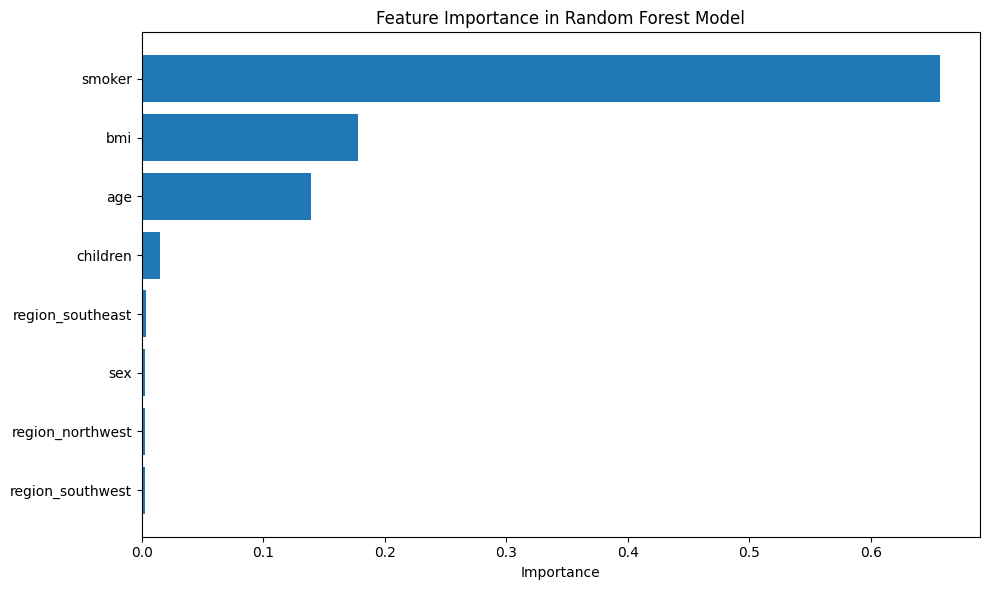

In [142]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*50)
print("Feature Importance:")
print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 25. Prediction vs Actual Plot

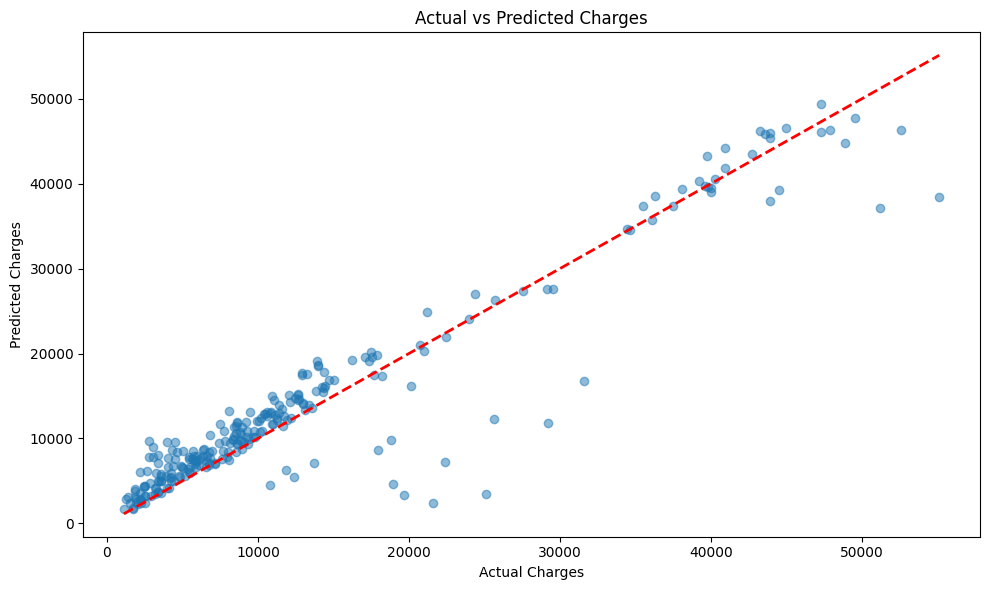


Pipeline completed successfully!


In [143]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges')
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("Pipeline completed successfully!")
print("="*50)

# 26. Prediction Results Table

In [144]:
print("\n" + "="*60)
print("PREDICTION RESULTS TABLE")
print("="*60)

results_df = pd.DataFrame({
    'Actual Charges': y_test.values,
    'Predicted Charges': y_pred_test,
    'Difference': y_test.values - y_pred_test,
    'Absolute Error': np.abs(y_test.values - y_pred_test)
})

print("\nPrediction Results (First 15 rows):")
print(results_df.head(15))


PREDICTION RESULTS TABLE

Prediction Results (First 15 rows):
    Actual Charges  Predicted Charges    Difference  Absolute Error
0      22462.04375       21888.741269    573.302481      573.302481
1      10601.63225       12668.433690  -2066.801440     2066.801440
2      12730.99960       14647.500365  -1916.500765     1916.500765
3       4137.52270        4107.403583     30.119117       30.119117
4       1875.34400        3813.764692  -1938.420692     1938.420692
5      13393.75600       13890.114456   -496.358456      496.358456
6      14001.13380       18621.707645  -4620.573845     4620.573845
7       3167.45585        3491.098352   -323.642502      323.642502
8       3393.35635        8000.600400  -4607.244050     4607.244050
9      11658.11505       11476.532161    181.582889      181.582889
10     36124.57370       35707.757388    416.816312      416.816312
11      4779.60230        5528.011200   -748.408900      748.408900
12     19673.33573        3351.666535  16321.669195  

# 27. Predict Charges for New / Unseen Data (Interactive)

In [145]:
def predict_new_data():
    """
    Interactive insurance charge predictor using SCALED and ENCODED data
    """
    print("\n" + "="*60)
    print(" INTERACTIVE INSURANCE CHARGE PREDICTOR")
    print(" (Using Scaled & Encoded Model)")
    print(" (Type 'quit' at any time to exit)")
    print("="*60)
    
    # Valid input ranges and options
    valid_regions = ['northeast', 'northwest', 'southeast', 'southwest']
    valid_sex = ['male', 'female']
    valid_smoker = ['yes', 'no']
    
    while True:
        print("\n" + "-"*60)
        print(" Please enter the following information:")
        print("-"*60)
        
        try:
            age_input = input(" Age (18-64): ").strip()
            if age_input.lower() == 'quit':
                print("\n Thank you! Prediction session ended.")
                break
            
            age = float(age_input)
            if not (18 <= age <= 64):
                print(" Age must be between 18 and 64.")
                continue
            
            sex = input(" Sex (male/female): ").strip().lower()
            if sex == 'quit':
                break
            if sex not in valid_sex:
                print(f"  Sex must be: {', '.join(valid_sex)}")
                continue
       
            bmi_input = input("  BMI (15-55): ").strip()
            if bmi_input.lower() == 'quit':
                break
            
            bmi = float(bmi_input)
            if not (15 <= bmi <= 55):
                print(" BMI must be between 15 and 55.")
                continue
            
            children_input = input(" Children (0-5): ").strip()
            if children_input.lower() == 'quit':
                break
            
            children = int(children_input)
            if not (0 <= children <= 5):
                print(" Children must be between 0 and 5.")
                continue
            
            smoker = input(" Smoker? (yes/no): ").strip().lower()
            if smoker == 'quit':
                break
            if smoker not in valid_smoker:
                print(f"  Must be: {', '.join(valid_smoker)}")
                continue
            
            region = input("  Region (northeast/northwest/southeast/southwest): ").strip().lower()
            if region == 'quit':
                break
            if region not in valid_regions:
                print(f"  Must be: {', '.join(valid_regions)}")
                continue
        
            new_data = pd.DataFrame({
                'age': [age],
                'sex': [sex],
                'bmi': [bmi],
                'children': [children],
                'smoker': [smoker],
                'region': [region]
            })
            
           
            new_data_encoded = new_data.copy()
            
            new_data_encoded['sex'] = 1 if sex == 'male' else 0
            
            new_data_encoded['smoker'] = 1 if smoker == 'yes' else 0
           
            region_dummies = pd.get_dummies(
                new_data_encoded['region'], 
                prefix='region', 
                drop_first=True 
            )
            new_data_encoded = pd.concat(
                [new_data_encoded.drop('region', axis=1), region_dummies], 
                axis=1
            )
            
            for col in ['region_northwest', 'region_southeast', 'region_southwest']:
                if col not in new_data_encoded.columns:
                    new_data_encoded[col] = 0
            
            column_order = [
                'age', 'sex', 'bmi', 'children', 'smoker',
                'region_northwest', 'region_southeast', 'region_southwest'
            ]
            new_data_encoded = new_data_encoded[column_order]
            
            numerical_cols = ['age', 'bmi', 'children']
            new_data_scaled = new_data_encoded.copy()
            
            new_data_scaled[numerical_cols] = scaler.transform(
                new_data_encoded[numerical_cols]
            )
            
            predicted_charge = rf_model.predict(new_data_scaled)[0]
            
            print(f"\n Predicted Annual Insurance Charge:")
            print(f"   ${predicted_charge:,.2f}")
            
            # Ask for another prediction
            print("\n" + "-"*60)
            another = input(" Make another prediction? (yes/no): ").strip().lower()
            if another not in ['yes', 'y']:
                print("\n Thank you! Session ended.")
                break
                
        except ValueError as e:
            print(f"\n Invalid format: {str(e)}")
            continue
            
        except Exception as e:
            print(f"\n Error: {str(e)}")
            continue

predict_new_data()


 INTERACTIVE INSURANCE CHARGE PREDICTOR
 (Using Scaled & Encoded Model)
 (Type 'quit' at any time to exit)

------------------------------------------------------------
 Please enter the following information:
------------------------------------------------------------

 Thank you! Prediction session ended.
